In [1]:
# import libraries
import pandas as pd
import re

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# NLTK Resources
nltk.download("punkt") # for word_tokenize
nltk.download("stopwords") # for stopwords
nltk.download("wordnet") # for WordNetLemmatizer
nltk.download("omw-1.4") # for WordNetLemmatizer to work with multiple languages
nltk.download("averaged_perceptron_tagger") # for nltk.pos_tag

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report


# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model



[nltk_data] Downloading package punkt to /Users/meng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/meng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/meng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/meng/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/meng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Read and Join the data

In [2]:
# read the data
fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")

In [3]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake.shape

(23481, 4)

In [5]:
fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [6]:
fake.title.value_counts()

title
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead                                                                  6
ELEMENTARY SCHOOL PLANS ‘BLACKS ONLY’ FIELD TRIP TO COLLEGE FOR THIRD GRADERS                                                                                          4
FORMER FBI ASST DIRECTOR: “Jim Comey ‘Danced With The Devil’…I’m Glad He’s Gone” [VIDEO]                                                                               4
AN INSIDE LOOK AT OBAMA’S 5-STAR SUMMER VACATION RETREAT: Meanwhile…62% Of Americans Won’t Be Taking A Vacation This Summer                                            3
GARY JOHNSON: Meet The “Creepy” Pro-Amnesty, Anti-Gun, Pro-TPP, Pro-Abortion, Democrat Party Operative And His Anti-Gun Rights, Friend Of Clinton’s VP Pick [VIDEO]    3
                                                                                                                                                     

In [7]:
fake = fake.drop_duplicates(subset='title', keep='first')

In [8]:
fake.title.value_counts()

title
 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing                                                                     1
BUZZFEED’S EDITOR-IN-CHIEF Attempts Lame Explanation Of Why He Published Fake News On Trump: “This was absolutely the right thing to do” [Video]    1
EPIC! TRUMP RESPONDS To Disgusting Fake Report From CNN And Buzzfeed: “I’m a GERMAPHOBE!” [Video]                                                   1
SAY WHAT? Trump-Hater, RINO John McCain Admits HE Handed Smear Dossier Outlining Claims Of Kremlin Blackmail To FBI                                 1
“YOU ARE FAKE NEWS!” TRUMP DESTROYS CNN Right In The Middle Of Press Conference [VIDEO]                                                             1
                                                                                                                                                   ..
 Friend Of Stanford Rapist: Not Everyone Who Rapes In College Is A Rapist                     

In [9]:
fake.shape

(17903, 4)

In [10]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [11]:
real.shape

(21417, 4)

In [12]:
real.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [13]:
real.title.value_counts()

title
Factbox: Trump fills top jobs for his administration                                14
Factbox: Contenders for senior jobs in Trump's administration                        8
Highlights: The Trump presidency on April 13 at 9:30 P.M. EDT/0130 GMT on Friday     8
Factbox: International reaction to arrest of Reuters reporters in Myanmar            6
Highlights: The Trump presidency on April 21 at 6:12 p.m. EDT/2212 GMT               5
                                                                                    ..
Obama, on last trip to Europe, warns against nationalism, populism                   1
A post-Trump SEC could shake up current policy                                       1
U.S. panel urges probe on whether China weakening U.S. militarily                    1
Trump team weighs 'infrastructure bank' to fund projects: Trump adviser              1
Indonesia to buy $1.14 billion worth of Russian jets                                 1
Name: count, Length: 20826, dtype: in

In [14]:
real = real.drop_duplicates(subset='title', keep='first')

In [15]:
real.title.value_counts()

title
As U.S. budget fight looms, Republicans flip their fiscal script                                 1
Thailand arrests woman wanted over deadly 2015 bombing at shrine                                 1
Kremlin says it is following situation in Ukraine's Luhansk region                               1
Kuwait's Emir in hospital for medical checks after cold: agency                                  1
Kremlin says no proof Russia was source of radioactive pollution                                 1
                                                                                                ..
Factbox: Trump to meet with retired General Petraeus, Mitt Romney                                1
Trump to pick Seema Verma for Centers for Medicare and Medicaid Services: transition official    1
Trump vows to end U.S.-Cuba 'deal' unless Havana makes better one                                1
Trump to announce transportation secretary pick: spokesman                                       1
Indo

In [16]:
real.shape

(20826, 4)

In [17]:
fake["label"] = 0

In [18]:
real["label"] = 1

In [19]:
fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [20]:
real.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [21]:
data = pd.concat([fake, real], ignore_index= True)

In [22]:
data.shape

(38729, 5)

In [23]:
print(data.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


### EDA

In [24]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38729 entries, 0 to 38728
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    38729 non-null  object
 1   text     38729 non-null  object
 2   subject  38729 non-null  object
 3   date     38729 non-null  object
 4   label    38729 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.5+ MB
None


In [25]:
print(data.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [26]:
print(data['label'].value_counts())

label
1    20826
0    17903
Name: count, dtype: int64


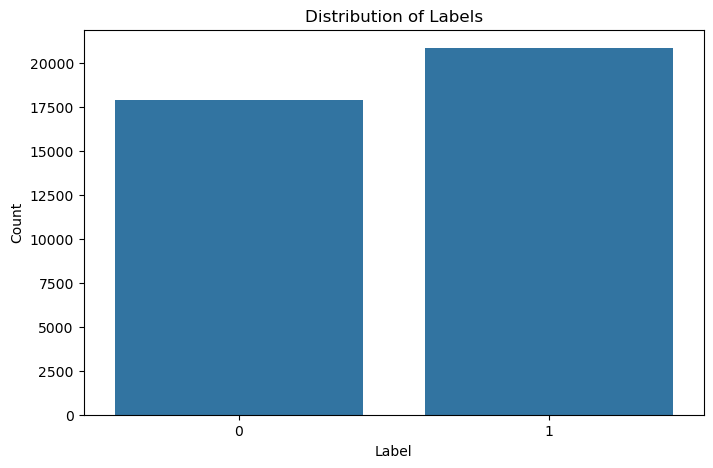

In [27]:
# plot the balance of the dataset
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=data)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [28]:
# longest sentence length 
def longest_sentence_length(text):
  return len(text.split())

data['maximum_length'] = data['title'].apply(lambda x : longest_sentence_length(x))
print('longest sentence having length:')
max_length = max(data['maximum_length'].values)
print(max_length)

longest sentence having length:
42


### Pre-processing

In [29]:
# Initialisation
stop_words_list = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# POS tag conversion function: Change 'NLTK.pos_tag' Pos tag format to WordNet format
def convert_to_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    
    elif tag.startswith("V"):
        return wordnet.VERB
    
    elif tag.startswith("N"):
        return wordnet.NOUN
    
    elif tag.startswith("R"):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN

# Text Preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters
    text = re.sub(r"[^\w\s']", '', text)  # Keep ' symbokl for contractions

    # Remove Mentions
    text = re.sub(r'@\w+', '', text)

    # Remove Hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens_list = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [word for word in tokens_list if word not in stop_words_list]
    
    # POS tagging
    # nltk.pos_tag will return a list of tuples (word, tag)
    tagged_tokens = nltk.pos_tag(filtered_tokens)
    
    # Lemmatization with POS tagging
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, pos = convert_to_wordnet_pos(tag))
        for word, tag in tagged_tokens
    ]
    
    return " ".join(lemmatized_tokens)

In [30]:
data['cleaned_title'] = data['title'].apply(preprocess_text)

In [31]:
print(data['cleaned_title'].head())

0    donald trump sends embarrass new year eve mess...
1    drunk brag trump staffer start russian collusi...
2    sheriff david clarke become internet joke thre...
3      trump obsess even obamas name cod website image
4      pope francis call donald trump christmas speech
Name: cleaned_title, dtype: object


### Split Dataset

In [32]:
X_title = data["cleaned_title"]
y_title = data["label"]

X_train_title, X_temp_title, y_train_title, y_temp_title = train_test_split(
    X_title, y_title, test_size = 0.2, random_state = 42, stratify = y_title
)
X_val_title, X_test_title, y_val_title, y_test_title = train_test_split(
    X_temp_title, y_temp_title, test_size = 0.5, random_state = 42, stratify = y_temp_title
)

### Train Models

#### 0. Pipeline Function

In [33]:
def pipeline(
    model_type,
    vectorizer_type,
    X_train,
    y_train,
    X_compare,
    y_compare,
    ngram_range):

    # Selecting the vectorizer
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(max_features = 250, ngram_range = ngram_range)

    elif vectorizer_type == 'bow':
        vectorizer = CountVectorizer(
            max_features = 250,   # limit the number of features to 250
            min_df = 10,           # at least 10 documents must contain the word
            max_df = 0.6,          # at most 60% of documents can contain the word
            ngram_range = ngram_range # (1, 2) # 1-gram and 2-gram
        )

    else:
        raise ValueError("vectorizer_type must be either 'tfidf' or 'bow'")
    
    # Selecting the model
    if model_type == 'logistic':
        model = LogisticRegression(penalty='l2', C=0.1,max_iter=1000)
    
    elif model_type == 'svm':
        model = LinearSVC(penalty='l2', C=0.1, max_iter=1000)
    
    elif model_type == 'naive_bayes':
        model = MultinomialNB(alpha=10)
    
    elif model_type == 'random_forest':
        model = RandomForestClassifier(
    n_estimators=100,
    max_depth=120,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=7)
    
    else:
        raise ValueError("model_type must be either 'logistic', 'svm', 'naive_bayes', or 'random_forest'")

    # Creating the pipeline
    pipe = Pipeline([
        ("vectorizer", vectorizer),
        ("classifier", model)
    ])

    # Fitting the model
    pipe.fit(X_train, y_train)

    # Making predictions
    y_pred_test = pipe.predict(X_compare)

    # Evaluating the model
    accuracy = accuracy_score(y_compare, y_pred_test)
    report = classification_report(y_compare, y_pred_test, output_dict = False)

    # Getting the model name
    modelname = f"{type(model).__name__} with {type(vectorizer).__name__}"

    # Printing the results
    print(f"===== Model: {modelname} =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")

    return pipe

#### BoW + Logistic Regression

In [34]:
pipeline(
    model_type = 'logistic',
    vectorizer_type = 'bow',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_val_title,
    y_compare = y_val_title,
    ngram_range = (1, 1)
)

===== Model: LogisticRegression with CountVectorizer =====
Accuracy: 0.8637
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1790
           1       0.83      0.93      0.88      2083

    accuracy                           0.86      3873
   macro avg       0.87      0.86      0.86      3873
weighted avg       0.87      0.86      0.86      3873



Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.6, max_features=250, min_df=10)),
                ('classifier', LogisticRegression(C=0.1, max_iter=1000))])

### Bag of Words

#### BoW + Naive Bayes

In [35]:
pipeline(
    model_type = 'naive_bayes',
    vectorizer_type = 'bow',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_val_title,
    y_compare = y_val_title,
    ngram_range = (1, 1)
)

===== Model: MultinomialNB with CountVectorizer =====
Accuracy: 0.8528
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.86      0.87      0.86      2083

    accuracy                           0.85      3873
   macro avg       0.85      0.85      0.85      3873
weighted avg       0.85      0.85      0.85      3873



Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.6, max_features=250, min_df=10)),
                ('classifier', MultinomialNB(alpha=10))])

#### Bow + SVM

In [36]:
pipeline(
    model_type = 'svm',
    vectorizer_type = 'bow',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_val_title,
    y_compare = y_val_title,
    ngram_range = (1, 1)
)

===== Model: LinearSVC with CountVectorizer =====
Accuracy: 0.8632
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1790
           1       0.84      0.93      0.88      2083

    accuracy                           0.86      3873
   macro avg       0.87      0.86      0.86      3873
weighted avg       0.87      0.86      0.86      3873



Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.6, max_features=250, min_df=10)),
                ('classifier', LinearSVC(C=0.1))])

#### Bow + Random Forest

In [37]:
pipeline(
    model_type = 'random_forest',
    vectorizer_type = 'bow',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_val_title,
    y_compare = y_val_title,
    ngram_range = (1, 1)
)

===== Model: RandomForestClassifier with CountVectorizer =====
Accuracy: 0.8552
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1790
           1       0.84      0.90      0.87      2083

    accuracy                           0.86      3873
   macro avg       0.86      0.85      0.85      3873
weighted avg       0.86      0.86      0.85      3873



Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.6, max_features=250, min_df=10)),
                ('classifier',
                 RandomForestClassifier(max_depth=120, min_samples_leaf=5,
                                        random_state=7))])

### TF-IDF

#### TF-IDF + Logistic Regression

In [38]:
pipeline(
    model_type = 'logistic',
    vectorizer_type = 'tfidf',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_val_title,
    y_compare = y_val_title,
    ngram_range = (1, 1)
)

===== Model: LogisticRegression with TfidfVectorizer =====
Accuracy: 0.8588
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1790
           1       0.83      0.92      0.88      2083

    accuracy                           0.86      3873
   macro avg       0.86      0.85      0.86      3873
weighted avg       0.86      0.86      0.86      3873



Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=250)),
                ('classifier', LogisticRegression(C=0.1, max_iter=1000))])

#### TF-IDF + Naive Bayes

In [39]:
pipeline(
    model_type = 'naive_bayes',
    vectorizer_type = 'tfidf',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_val_title,
    y_compare = y_val_title,
    ngram_range = (1, 1)
)

===== Model: MultinomialNB with TfidfVectorizer =====
Accuracy: 0.8549
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1790
           1       0.85      0.88      0.87      2083

    accuracy                           0.85      3873
   macro avg       0.85      0.85      0.85      3873
weighted avg       0.85      0.85      0.85      3873



Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=250)),
                ('classifier', MultinomialNB(alpha=10))])

#### TF-IDF + SVM

In [40]:
pipeline(
    model_type = 'svm',
    vectorizer_type = 'tfidf',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_val_title,
    y_compare = y_val_title,
    ngram_range = (1, 1)
)

===== Model: LinearSVC with TfidfVectorizer =====
Accuracy: 0.8639
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1790
           1       0.84      0.92      0.88      2083

    accuracy                           0.86      3873
   macro avg       0.87      0.86      0.86      3873
weighted avg       0.87      0.86      0.86      3873



Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=250)),
                ('classifier', LinearSVC(C=0.1))])

#### TF-IDF + Random Forest

In [41]:
pipeline(
    model_type = 'random_forest',
    vectorizer_type = 'tfidf',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_val_title,
    y_compare = y_val_title,
    ngram_range = (1, 1)
)

===== Model: RandomForestClassifier with TfidfVectorizer =====
Accuracy: 0.8564
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1790
           1       0.84      0.90      0.87      2083

    accuracy                           0.86      3873
   macro avg       0.86      0.85      0.85      3873
weighted avg       0.86      0.86      0.86      3873



Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=250)),
                ('classifier',
                 RandomForestClassifier(max_depth=120, min_samples_leaf=5,
                                        random_state=7))])

### Neural Network Model

#### CNN

In [42]:
# Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data["cleaned_title"])

X = tokenizer.texts_to_sequences(data["cleaned_title"])
maxlen = max(len(x) for x in X)
X = pad_sequences(X, maxlen=maxlen)

y = data['label'].values

vocab_size = 5000


In [43]:
# train, validation, test split
X_train_cnn, X_temp_cnn, y_train_cnn, y_temp_cnn = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_cnn, X_test_cnn, y_val_cnn, y_test_cnn = train_test_split(X_temp_cnn, y_temp_cnn, test_size=0.5, random_state=42)

In [44]:
# input shape
inputs = Input(shape=(maxlen,))

# embedding layer
x = Embedding(input_dim=vocab_size, output_dim=64)(inputs)

# convolutional layers with L2 regularization
x = Conv1D(64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001))(x)

# Dropout to prevent overfitting
x = Dropout(0.5)(x)

# Pooling
x = GlobalMaxPooling1D()(x)

# another Dropout layer before output
x = Dropout(0.5)(x)

# output layer
outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(x)

# build the model
model_cnn = Model(inputs=inputs, outputs=outputs)

# compile the model
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model summary
model_cnn.summary()

2025-05-30 06:15:10.357785: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-30 06:15:10.357931: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-30 06:15:10.357941: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1748578510.358406 136797672 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748578510.358842 136797672 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 29, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 25, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,609 (1.30 MB)

 Trainable params: 340,609 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [46]:
history_cnn = model_cnn.fit(
        X_train_cnn, y_train_cnn,
        validation_data=(X_val_cnn, y_val_cnn),
        epochs=10,
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping]
    )

Epoch 1/10


2025-05-30 06:15:10.986293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1748578510.992218 136797672 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8145 - loss: 0.4460 - val_accuracy: 0.9548 - val_loss: 0.1964
Epoch 2/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9637 - loss: 0.1360 - val_accuracy: 0.9558 - val_loss: 0.1696
Epoch 3/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9724 - loss: 0.1066 - val_accuracy: 0.9546 - val_loss: 0.1623
Epoch 4/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9798 - loss: 0.0904 - val_accuracy: 0.9525 - val_loss: 0.1548
Epoch 5/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9840 - loss: 0.0771 - val_accuracy: 0.9509 - val_loss: 0.1548
Epoch 6/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9863 - loss: 0.0714 - val_accuracy: 0.9522 - val_loss: 0.1518
Epoch 7/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9892 - loss: 0.0646 - val_accuracy: 0.9466 - val_loss: 0.1584
Epoch 8/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9916 - loss: 0.0583 - val_accuracy: 0.9

In [47]:
# evaluate the model
loss, accuracy = model_cnn.evaluate(X_val_cnn, y_val_cnn, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")
# make predictions
y_pred_cnn = model_cnn.predict(X_val_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)

# classification report
print(f"===== Model: CNN =====")
report = classification_report(y_val_cnn, y_pred_cnn, target_names=['Fake', 'Real'])
print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{report}")

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9523 - loss: 0.1498
Test Accuracy: 0.9504
 44/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

E0000 00:00:1748578600.036808 136797672 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
===== Model: CNN =====
Accuracy: 0.9504
Classification Report:
              precision    recall  f1-score   support

        Fake       0.95      0.94      0.95      1798
        Real       0.95      0.96      0.95      2075

    accuracy                           0.95      3873
   macro avg       0.95      0.95      0.95      3873
weighted avg       0.95      0.95      0.95      3873



### Compare all the model on the test dataset

In [48]:
# BOW + Logistic Regression
pipeline(
    model_type = 'logistic',
    vectorizer_type = 'bow',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_test_title,
    y_compare = y_test_title,
    ngram_range = (1, 1)
)

===== Model: LogisticRegression with CountVectorizer =====
Accuracy: 0.8722
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      1791
           1       0.84      0.94      0.89      2082

    accuracy                           0.87      3873
   macro avg       0.88      0.87      0.87      3873
weighted avg       0.88      0.87      0.87      3873



Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.6, max_features=250, min_df=10)),
                ('classifier', LogisticRegression(C=0.1, max_iter=1000))])

In [49]:
# TF-IDF + Naive Bayes
pipeline(
    model_type = 'naive_bayes',
    vectorizer_type = 'tfidf',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_test_title,
    y_compare = y_test_title,
    ngram_range = (1, 1)
)

===== Model: MultinomialNB with TfidfVectorizer =====
Accuracy: 0.8603
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1791
           1       0.86      0.88      0.87      2082

    accuracy                           0.86      3873
   macro avg       0.86      0.86      0.86      3873
weighted avg       0.86      0.86      0.86      3873



Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=250)),
                ('classifier', MultinomialNB(alpha=10))])

In [50]:
# TF-IDF + SVM
pipeline(
    model_type = 'svm',
    vectorizer_type = 'tfidf',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_test_title,
    y_compare = y_test_title,
    ngram_range = (1, 1)
)

===== Model: LinearSVC with TfidfVectorizer =====
Accuracy: 0.8745
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1791
           1       0.86      0.92      0.89      2082

    accuracy                           0.87      3873
   macro avg       0.88      0.87      0.87      3873
weighted avg       0.88      0.87      0.87      3873



Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=250)),
                ('classifier', LinearSVC(C=0.1))])

In [51]:
# TF-IDF + Random Forest
pipeline(
    model_type = 'random_forest',
    vectorizer_type = 'tfidf',
    X_train = X_train_title,
    y_train = y_train_title,
    X_compare = X_test_title,
    y_compare = y_test_title,
    ngram_range = (1, 1)
)

===== Model: RandomForestClassifier with TfidfVectorizer =====
Accuracy: 0.8678
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1791
           1       0.85      0.92      0.88      2082

    accuracy                           0.87      3873
   macro avg       0.87      0.86      0.87      3873
weighted avg       0.87      0.87      0.87      3873



Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=250)),
                ('classifier',
                 RandomForestClassifier(max_depth=120, min_samples_leaf=5,
                                        random_state=7))])

In [52]:
# evaluate the model
loss, accuracy = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")
# make predictions
y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)

# classification report
print(f"===== Model: CNN =====")
report = classification_report(y_test_cnn, y_pred_cnn, target_names=['Fake', 'Real'])
print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{report}")

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9464 - loss: 0.1706
Test Accuracy: 0.9424
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
===== Model: CNN =====
Accuracy: 0.9424
Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.93      0.94      1777
        Real       0.94      0.95      0.95      2096

    accuracy                           0.94      3873
   macro avg       0.94      0.94      0.94      3873
weighted avg       0.94      0.94      0.94      3873

